In [1]:
import sys
import os
import numpy as np
import multiprocessing
import dill
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


from util_functions import *
from uncertainty_analysis import *
from sim_helper_functions import *
from plot_utils import *
configure_plot(plt)

In [2]:
base_folder = '/home/aaj54/group-testing/notebooks/pnas_paper_figs/jun_23_sims/sensitivity_sims_1624479629/'


def get_sim_output_fnames(param):
    subfolder = '{}/{}/'.format(base_folder, param)
    fnames = os.listdir(subfolder)
    return [subfolder + fname for fname in fnames]


def map_fpath_to_params(fpath):
    fname = fpath.split('/')[-1]
    if 'pess' in fname:
        point_type = 'pess'
    elif 'centre' in fname:
        point_type = 'centre'
    else:
        raise(Exception())
    
    last_fname_part = fname.split('_')[-1]
    x_axis_idx = int(last_fname_part.split('.')[0])
    
    return point_type, x_axis_idx


def load_plot_data(param):
    sim_fpaths = get_sim_output_fnames(param)
    sim_results_df = load_sim_output(sim_fpaths)
    sim_params = [map_fpath_to_params(fpath) for fpath in sim_fpaths]
    
    centre_data = {'p10': [-1] * 13, 'p50': [-1] * 13, 'p90': [-1] * 13}
    pess_data = {'p10': [-1] * 13, 'p50': [-1] * 13, 'p90': [-1] * 13}
    
    plot_data = {'centre': centre_data, 'pess': pess_data}
    
    xlabels = {'centre': [-1]*13, 'pess': [-1]*13}
    
    
    # above we harcoded 13 sim results for each sim type, 
    # so just making sure the data agrees with this assumption
    n_sims = len(sim_fpaths)
    print(n_sims)
    assert(n_sims == 26) 
    
    for idx in range(n_sims):
        sim_type, sim_idx = sim_params[idx]
        
        plot_data[sim_type]['p10'][sim_idx] = sim_results_df.iloc[idx]['res_cornell_inf_10']
        plot_data[sim_type]['p50'][sim_idx] = sim_results_df.iloc[idx]['res_cornell_inf_50']
        plot_data[sim_type]['p90'][sim_idx] = sim_results_df.iloc[idx]['res_cornell_inf_90']
        
        xlabels[sim_type][sim_idx] = sim_results_df.iloc[idx][param]

    return xlabels, plot_data


def load_virtual_plot_data(param):
    sim_fpaths = get_sim_output_fnames(param)
    sim_results_df = load_sim_output(sim_fpaths)
    sim_params = [map_fpath_to_params(fpath) for fpath in sim_fpaths]
    
    centre_data = {'p10': [-1] * 13, 'p50': [-1] * 13, 'p90': [-1] * 13}
    pess_data = {'p10': [-1] * 13, 'p50': [-1] * 13, 'p90': [-1] * 13}
    
    plot_data = {'centre': centre_data, 'pess': pess_data}
    
    xlabels = {'centre': [-1]*13, 'pess': [-1]*13}
    
    
    # above we harcoded 13 sim results for each sim type, 
    # so just making sure the data agrees with this assumption
    n_sims = len(sim_fpaths)
    print(n_sims)
    assert(n_sims == 26) 
    
    for idx in range(n_sims):
        sim_type, sim_idx = sim_params[idx]
        
        plot_data[sim_type]['p10'][sim_idx] = sim_results_df.iloc[idx]['res_cornell_inf_10']
        plot_data[sim_type]['p50'][sim_idx] = sim_results_df.iloc[idx]['res_cornell_inf_50']
        plot_data[sim_type]['p90'][sim_idx] = sim_results_df.iloc[idx]['res_cornell_inf_90']
        
        xlabels[sim_type][sim_idx] = sim_results_df.iloc[idx][param]

    return xlabels, plot_data



In [3]:
plot_data = load_plot_data('ct_mult')

26


In [3]:
def generate_sensitivity_plot(param_name, xlabel):
    %matplotlib inline

    xlabels, plot_data = load_plot_data(param_name)

    plt.figure(figsize=(10,6))

    plt.plot(xlabels['centre'], plot_data['centre']['p50'], color='blue', marker='o', label='Nominal')
    plt.fill_between(xlabels['centre'], plot_data['centre']['p10'], plot_data['centre']['p90'], alpha=0.1, color='blue')

    plt.plot(xlabels['pess'], plot_data['pess']['p50'], color='orange', marker='o', label='Pessimistic (Residential)')
    plt.fill_between(xlabels['pess'], plot_data['pess']['p10'], plot_data['pess']['p90'], alpha=0.1, color='orange')

    plt.xlabel(xlabel)
    plt.ylabel("Cornell Residential Infections")
    plt.legend()
    # plt.rc('xtick', labelsize=12)
    # plt.rc('ytick', labelsize=12) 
#     plt.rcParams.update({'font.size': 22})
    plt.show()


26


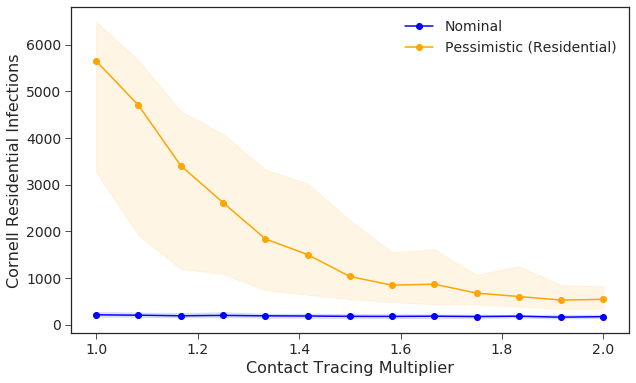

In [4]:
generate_sensitivity_plot('ct_mult', "Contact Tracing Multiplier")

26


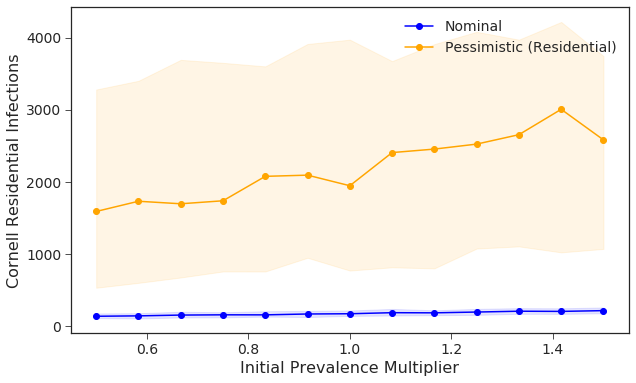

In [5]:
generate_sensitivity_plot('inital_prev_mult', "Initial Prevalence Multiplier")

26


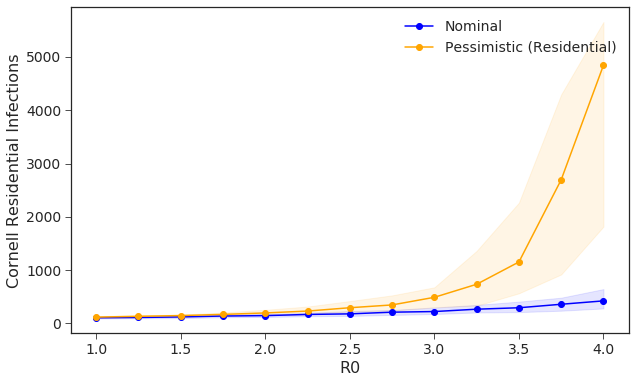

In [6]:
generate_sensitivity_plot('R0', "R0")

26


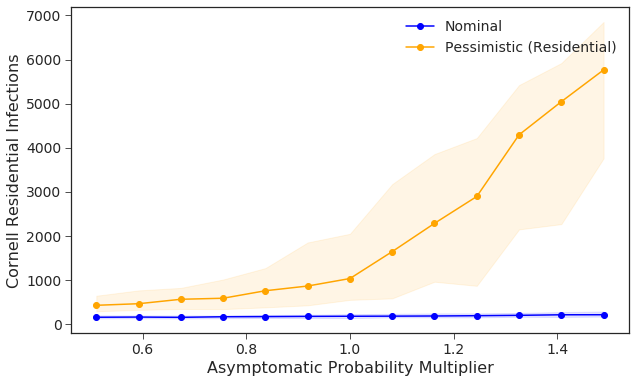

In [7]:
generate_sensitivity_plot('asymp_prob_mult', "Asymptomatic Probability Multiplier")

26


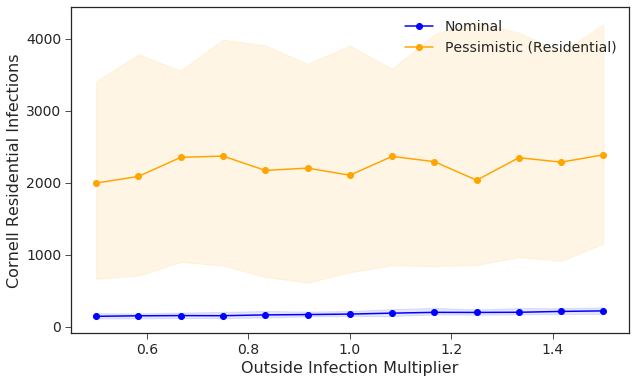

In [8]:
generate_sensitivity_plot('outside_inf_mult', "Outside Infection Multiplier")

26


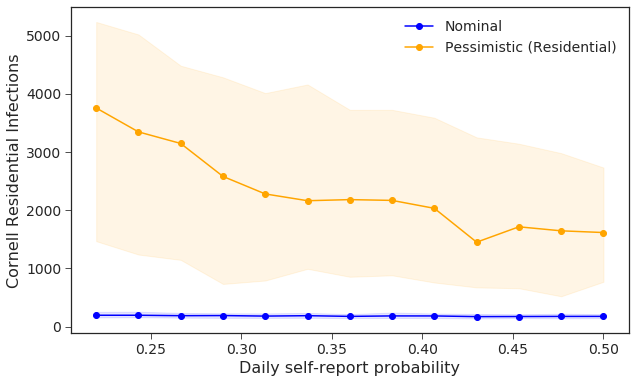

In [9]:
generate_sensitivity_plot('daily_self_report_prob', "Daily self-report probability")

26


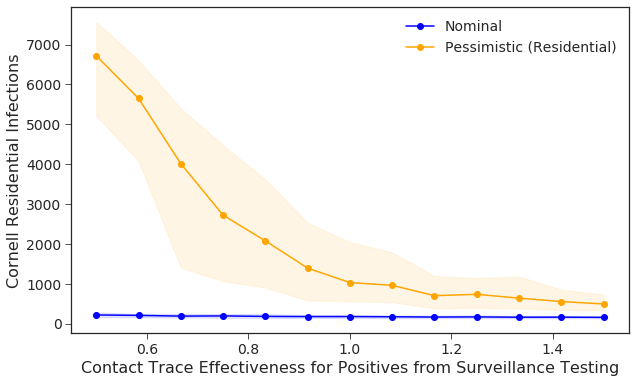

In [10]:
generate_sensitivity_plot('ct_testing_ratio', "Contact Trace Effectiveness for Positives from Surveillance Testing")

26


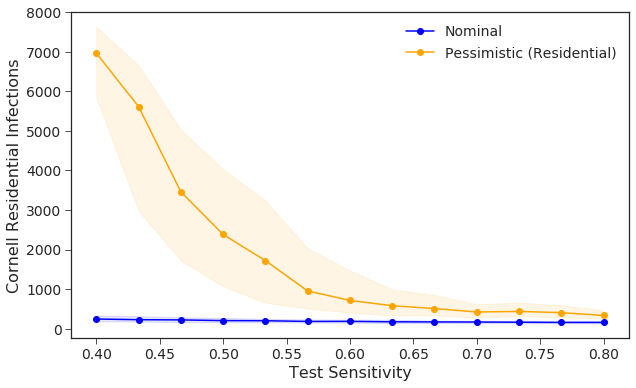

In [11]:
generate_sensitivity_plot('test_sensitivity', "Test Sensitivity")

26


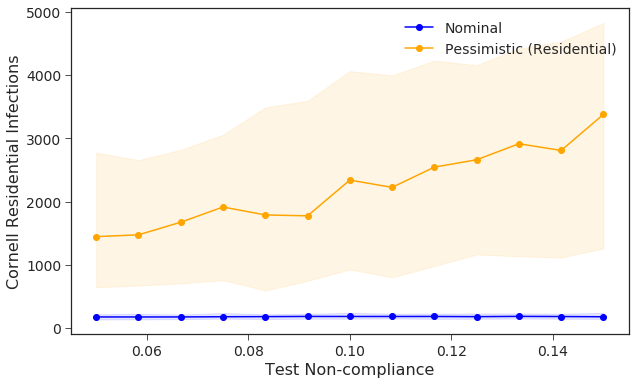

In [12]:
generate_sensitivity_plot('test_noncompliance', "Test Non-compliance")

26


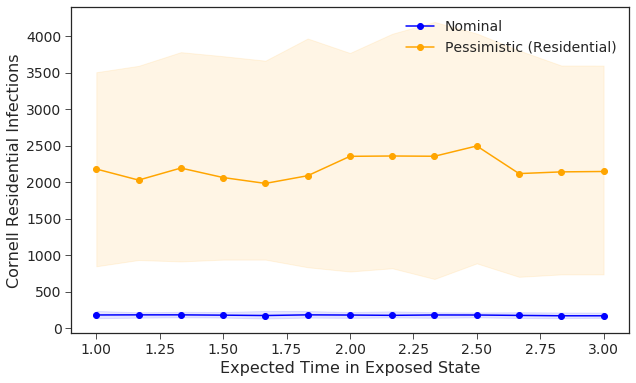

In [13]:
generate_sensitivity_plot('E_time', "Expected Time in Exposed State")

26


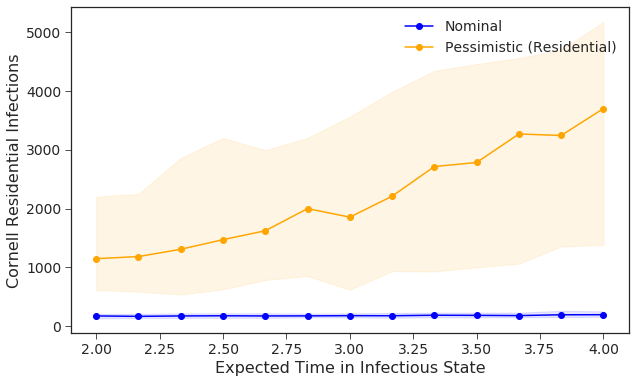

In [16]:
generate_sensitivity_plot('ID_time', "Expected Time in Infectious State")

26


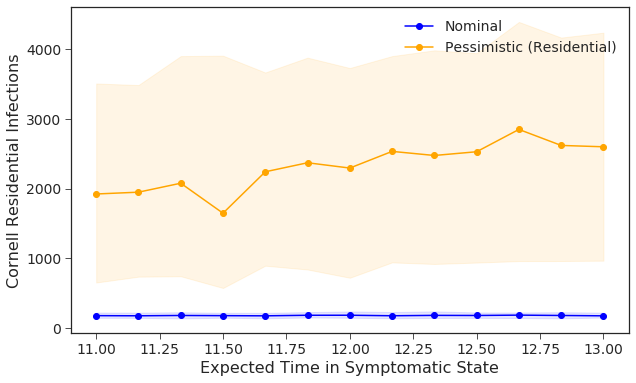

In [15]:
generate_sensitivity_plot('Sy_time', "Expected Time in Symptomatic State")

# Virtual Param Sensitivty Analysis

In [17]:
def launch_virtual_sensitivity_analysis(centre, param, base_folder, nreps=50):
    param_lb = PARAM_BOUNDS[param][0]
    param_ub = PARAM_BOUNDS[param][1]

    centre_lb = centre.copy()
    centre_lb[param] = param_lb

    centre_ub = centre.copy()
    centre_ub[param] = param_ub

    centre_points = get_points_on_line(centre_lb, centre_ub, mult_lb=0, mult_ub=1)

#     pess_lb = pess.copy()
#     pess_lb[param] = param_lb
#     pess_ub = pess.copy()
#     pess_ub[param] = param_ub

#     pess_points = get_points_on_line(pess_lb, pess_ub, mult_lb=0, mult_ub=1)


    folder_name = '{}/{}/'.format(base_folder, param)
    os.mkdir(folder_name)

    centre_fnames = [folder_name + 'centre_mult_{}.dill'.format(mult) for mult in \
                   range(len(centre_points))]

#     pess_fnames = [folder_name + 'pess_mult_{}.dill'.format(mult) for mult in \
#                    range(len(pess_points))]

    uncertainty_points = centre_points
#     uncertainty_points = centre_points + pess_points
    fnames = centre_fnames
#     fnames = centre_fnames + pess_fnames
    processes = run_sims_new_process(uncertainty_points, fnames, nreps=nreps, run_only_residential=False,
            wait_for_processes_to_join=False)
    return processes

In [31]:
# lhs_output_sim_files = []
# for i in range(2000):
#     fname = '/home/aaj54/group-testing/notebooks/apr_29_scenarios/point_{}.dill'.format(i)
#     lhs_output_sim_files.append(fname)

# scenario_data = load_sim_output(lhs_output_sim_files)
# res_results = residential_regression(scenario_data)
# res_pessimistic = calculate_pessimistic_scenario(res_results)
centre = get_centre_point()

base_folder = './jun_23_sims/virtual_sensitivity_sims_{}/'.format(get_timestamp())
os.mkdir(base_folder)

processes = []

#for param in SHORT_PARAM_LIST:
for param in ['virtual_pop_size']:
    processes.extend(launch_virtual_sensitivity_analysis(centre, param, base_folder,nreps=100))

print("finished launching processes, waiting for them to finish")
for p in processes:
    p.join()

/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load

launched 13 processes
finished launching processes, waiting for them to finish
running sim with id 3, nreps 100, T 112, filename ./jun_23_sims/virtual_sensitivity_sims_1625580327//virtual_pop_size/centre_mult_2.dill, run_only_residential False
running sim with id 5, nreps 100, T 112, filename ./jun_23_sims/virtual_sensitivity_sims_1625580327//virtual_pop_size/centre_mult_4.dill, run_only_residential False
running sim with id 4, nreps 100, T 112, filename ./jun_23_sims/virtual_sensitivity_sims_1625580327//virtual_pop_size/centre_mult_3.dill, run_only_residential False
running residential sim with id 3
running residential sim with id 5
running residential sim with id 4
running sim with id 9, nreps 100, T 112, filename ./jun_23_sims/virtual_sensitivity_sims_1625580327//virtual_pop_size/centre_mult_8.dill, run_only_residential False
running residential sim with id 9
running sim with id 1, nreps 100, T 112, filename ./jun_23_sims/virtual_sensitivity_sims_1625580327//virtual_pop_size/centre_

In [32]:
# base_folder = '/home/aaj54/group-testing/notebooks/pnas_paper_figs/jun_23_sims/virtual_sensitivity_sims_1625518831/'
base_folder = '/home/aaj54/group-testing/notebooks/pnas_paper_figs/jun_23_sims/virtual_sensitivity_sims_1625580327/'

def get_sim_output_fnames(param):
    subfolder = '{}/{}/'.format(base_folder, param)
    fnames = os.listdir(subfolder)
    return [subfolder + fname for fname in fnames]


def map_fpath_to_params(fpath):
    fname = fpath.split('/')[-1]
    if 'pess' in fname:
        point_type = 'pess'
    elif 'centre' in fname:
        point_type = 'centre'
    else:
        raise(Exception())
    
    last_fname_part = fname.split('_')[-1]
    x_axis_idx = int(last_fname_part.split('.')[0])
    
    return point_type, x_axis_idx


# def load_plot_data(param):
#     sim_fpaths = get_sim_output_fnames(param)
#     sim_results_df = load_sim_output(sim_fpaths)
#     sim_params = [map_fpath_to_params(fpath) for fpath in sim_fpaths]
    
#     centre_data = {'p10': [-1] * 13, 'p50': [-1] * 13, 'p90': [-1] * 13}
#     pess_data = {'p10': [-1] * 13, 'p50': [-1] * 13, 'p90': [-1] * 13}
    
#     plot_data = {'centre': centre_data, 'pess': pess_data}
    
#     xlabels = {'centre': [-1]*13, 'pess': [-1]*13}
    
    
#     # above we harcoded 13 sim results for each sim type, 
#     # so just making sure the data agrees with this assumption
#     n_sims = len(sim_fpaths)
#     print(n_sims)
#     assert(n_sims == 26) 
    
#     for idx in range(n_sims):
#         sim_type, sim_idx = sim_params[idx]
        
#         plot_data[sim_type]['p10'][sim_idx] = sim_results_df.iloc[idx]['res_cornell_inf_10']
#         plot_data[sim_type]['p50'][sim_idx] = sim_results_df.iloc[idx]['res_cornell_inf_50']
#         plot_data[sim_type]['p90'][sim_idx] = sim_results_df.iloc[idx]['res_cornell_inf_90']
        
#         xlabels[sim_type][sim_idx] = sim_results_df.iloc[idx][param]

#     return xlabels, plot_data


def load_virtual_plot_data(param):
    sim_fpaths = get_sim_output_fnames(param)
    sim_results_df = load_sim_output(sim_fpaths)
    sim_params = [map_fpath_to_params(fpath) for fpath in sim_fpaths]
    
    centre_data = {'p10': [-1] * 13, 'p50': [-1] * 13, 'p90': [-1] * 13}
#     pess_data = {'p10': [-1] * 13, 'p50': [-1] * 13, 'p90': [-1] * 13}
    
    plot_data = {'centre': centre_data}#, 'pess': pess_data}
    
    xlabels = {'centre': [-1]*13}#, 'pess': [-1]*13}
    
    
    # above we harcoded 13 sim results for each sim type, 
    # so just making sure the data agrees with this assumption
    n_sims = len(sim_fpaths)
    print(n_sims)
    assert(n_sims == 13) #26) 
    
    for idx in range(n_sims):
        sim_type, sim_idx = sim_params[idx]
        
        plot_data[sim_type]['p10'][sim_idx] = sim_results_df.iloc[idx]['vir_cornell_inf_10']
        plot_data[sim_type]['p50'][sim_idx] = sim_results_df.iloc[idx]['vir_cornell_inf_50']
        plot_data[sim_type]['p90'][sim_idx] = sim_results_df.iloc[idx]['vir_cornell_inf_90']
        
        xlabels[sim_type][sim_idx] = sim_results_df.iloc[idx][param]

    return xlabels, plot_data



In [28]:
def generate_sensitivity_plot(param_name, xlabel, x_axis_population=False):
    %matplotlib inline

    xlabels, plot_data = load_virtual_plot_data(param_name)

    plt.figure(figsize=(10,6))

    plt.plot(xlabels['centre'], plot_data['centre']['p50'], color='blue', marker='o', label='Nominal')
    plt.fill_between(xlabels['centre'], plot_data['centre']['p10'], plot_data['centre']['p90'], alpha=0.1, color='blue')

#     plt.plot(xlabels['pess'], plot_data['pess']['p50'], color='orange', marker='o', label='Pessimistic (Residential)')
#     plt.fill_between(xlabels['pess'], plot_data['pess']['p10'], plot_data['pess']['p90'], alpha=0.1, color='orange')

    if x_axis_population:
        plt.xticks([0,1], labels=['4500 UGs\n4770 GS other', '7950 UGs\n5850 GS other'])
    plt.xlabel(xlabel)
    plt.ylabel("Cornell Virtual Infections")
    plt.legend()
    # plt.rc('xtick', labelsize=12)
    # plt.rc('ytick', labelsize=12) 
#     plt.rcParams.update({'font.size': 22})
    plt.show()


13


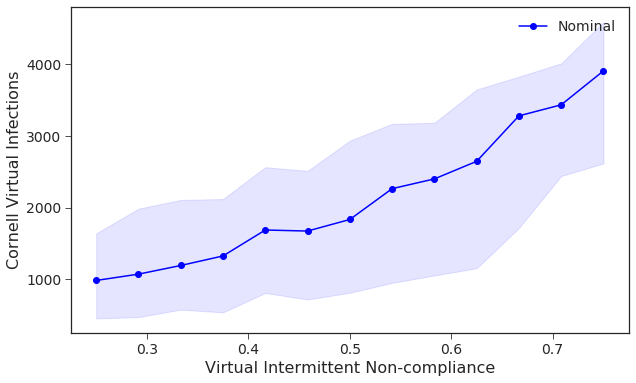

In [26]:
generate_sensitivity_plot('intermittent_non-compliance', 'Virtual Intermittent Non-compliance')

13


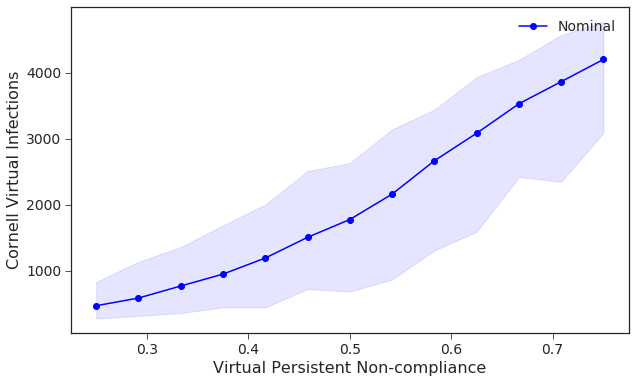

In [27]:
generate_sensitivity_plot('virtual_noncompliance', 'Virtual Persistent Non-compliance')

13


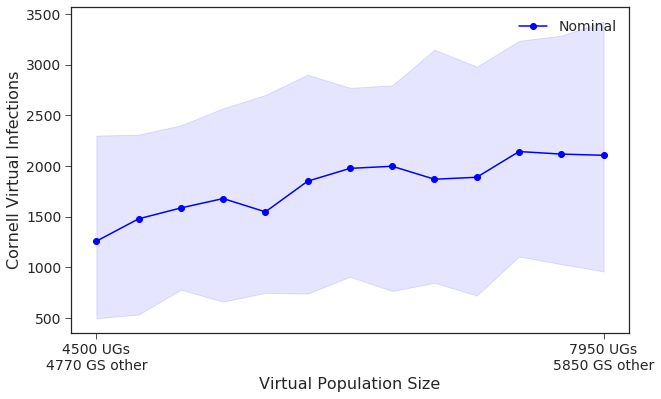

In [33]:
generate_sensitivity_plot('virtual_pop_size', 'Virtual Population Size', x_axis_population=True)

13


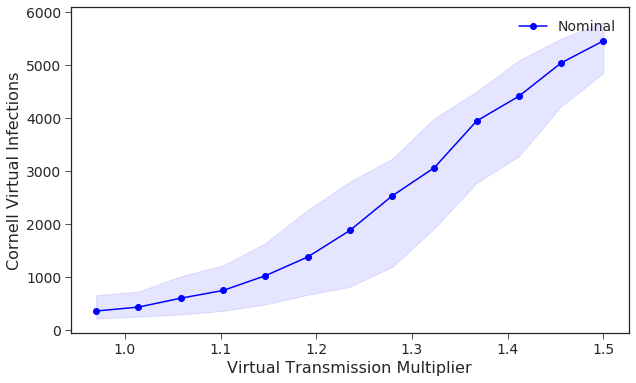

In [30]:
generate_sensitivity_plot('virtual_r0_mult', 'Virtual Transmission Multiplier')

In [40]:
plot_data

{'centre': {'p10': [167.0,
   178.0,
   143.8,
   151.9,
   148.0,
   156.8,
   155.4,
   138.8,
   158.7,
   149.9,
   149.9,
   157.2,
   151.9],
  'p50': [219.0,
   210.5,
   198.0,
   199.0,
   189.0,
   203.5,
   188.0,
   193.0,
   179.5,
   199.0,
   184.0,
   183.5,
   183.0],
  'p90': [268.3,
   257.40000000000003,
   253.4,
   262.2,
   232.2,
   253.4,
   230.39999999999998,
   230.7,
   219.20000000000005,
   249.20000000000002,
   234.10000000000002,
   231.3,
   228.60000000000002]},
 'pess': {'p10': [682.1,
   632.9000000000001,
   570.6,
   561.5,
   637.6,
   462.1,
   506.59999999999997,
   375.0,
   437.79999999999995,
   393.0,
   370.8,
   362.7,
   332.9],
  'p50': [1503.5,
   1375.5,
   943.5,
   1062.5,
   1042.5,
   930.0,
   796.0,
   660.5,
   777.5,
   740.5,
   670.0,
   580.5,
   563.0],
  'p90': [2531.0,
   2261.2000000000003,
   2369.4,
   1929.4,
   1900.9,
   1676.4,
   1490.1000000000001,
   1093.1000000000001,
   1470.1,
   1417.7000000000003,
   115

In [31]:
sim_fpaths = get_sim_output_fnames('ct_mult')
#sim_results = load_sim_output(sim_fpaths)
for fpath in sim_fpaths:
    print(map_fpath_to_params(fpath))

('pess', 10)
('pess', 6)
('pess', 12)
('centre', 7)
('pess', 11)
('centre', 9)
('pess', 8)
('pess', 9)
('centre', 2)
('centre', 8)
('pess', 3)
('centre', 11)
('pess', 7)
('pess', 5)
('pess', 4)
('centre', 12)
('centre', 3)
('centre', 0)
('pess', 2)
('pess', 1)
('pess', 0)
('centre', 1)
('centre', 10)
('centre', 4)
('centre', 5)
('centre', 6)


In [26]:
sim_fnames[0]

'/home/jmc678/covid_data/group-testing/notebooks/pnas_paper_figs/sensitivity_sims_1620271857//ct_mult/pess_mult_10.dill'

In [22]:
type(sim_results)

pandas.core.frame.DataFrame

In [23]:
sim_results.shape

(26, 28)

In [34]:
sim_results.iloc[0]

asymp_prob_mult                   1.152210
inital_prev_mult                  1.051377
R0                                3.525612
outside_inf_mult                  1.024138
daily_self_report_prob            0.346394
ct_mult                           1.450995
ct_testing_ratio                  0.840888
test_sensitivity                  0.521040
test_noncompliance                0.105169
E_time                            1.978106
ID_time                           3.100160
Sy_time                          11.997462
virtual_noncompliance             0.500000
intermittent_non-compliance       0.500000
virtual_r0_mult                   1.235000
virtual_pop_size                  0.500000
res_cornell_inf_10              370.800000
res_cornell_inf_50              670.000000
res_cornell_inf_90             1156.000000
res_ithaca_inf_10               262.600000
res_ithaca_inf_50               307.000000
res_ithaca_inf_90               362.100000
vir_cornell_inf_10             7641.800000
vir_cornell